<DIV ALIGN=CENTER>

# Dimension Reduction
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore how to effectively use the ensemble
technique of boosting by using Gradient Boosted Trees (GBT). First, we
repeat the analysis of the Iris and hand-written digit data used in the
[DT][l1] and [RF][l2] IPython Notebooks. However, we now switch to the
GBT algorithm. Throughout this Notebook, you should think about how
these results from this algorithm are different than the results from
the other algorithms, in particular the RF algorithm that employs
baggin. Also, explore how changes in the default parameters might affect
the performance of this algorithm, such as using different loss
functions or changing the numebr of estimators.

First, we will setup this Notebook, and then introduce the Iris data,
before making classifications for this data by using the scikit learn's
[Gradient Boosted Trees][gbtsk] algorithm.

-----
[l1]: intro2dt.ipynb
[l2]: intro2rf.ipynb
[gbtsk]: http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----

## Iris Data

To begin exploring PCA, we will use the classic
[_Iris_ dataset][id], which is included by default with the Seaborn
library (note this same data set is also included with scikit-learn).
First, we will load the data set into this Notebook, and construct a pair
plot demonstrating the relationships between the different dimensions
(this code and resulting figure are also included in the Seaborn
documentation). The four primary dimensions of the data
include Sepal Length, Sepal Width, Petal Length, and Petal Width, which
can be seen from the following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. 

-----
[id]: https://en.wikipedia.org/wiki/Iris_flower_data_set

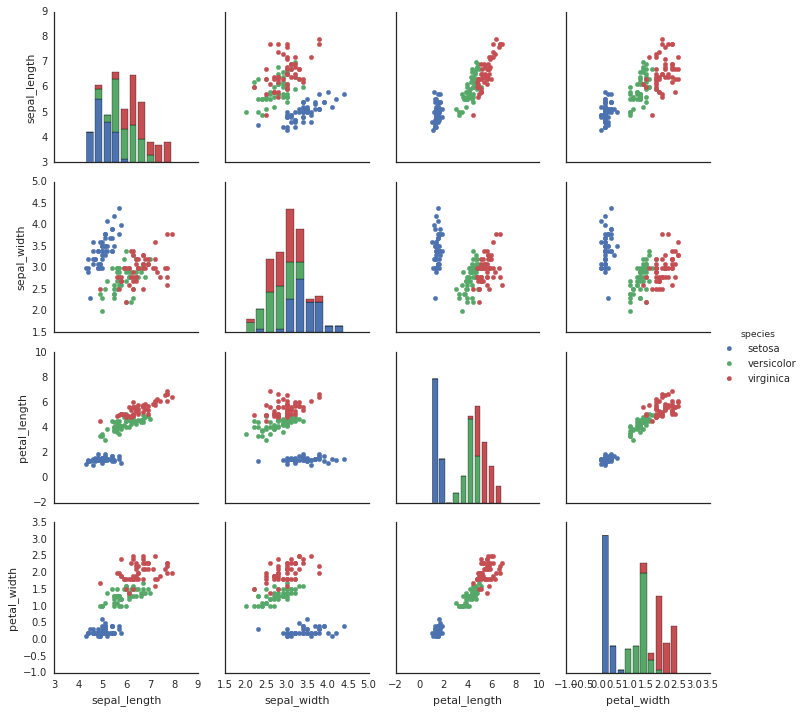

In [2]:
sns.set(style="white")

# Load the Iris Data
iris = sns.load_dataset("iris")

# Make pair plot
g = sns.PairGrid(iris, hue="species")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

# Lets explicitly set the axes limits
axes = g.axes

lim = [(3, 9), (1.5, 5), (-2, 10), (-1, 3.5)]

for i in range(len(lim)):
    for j in range(len(lim)):
        axes[i, j].set_xlim(lim[j])
        axes[i, j].set_ylim(lim[i])

As the previous figure illustrates, the three types of Iris cluster
naturally in these dimensions, with minimal overlap. Thus we can expect
that we don't need all four dimensions (or features) to perform machine
learning on these data. To formalize this, we can perform dimensionality
reduction on these data to identify the most important features in the
data.

-----

## [Dimensionality Reduction][dr]

When confronted with a large, multi-dimensional data set, one approach
to simplify any subsequent analysis is to reduce the number of
dimensions that must be processed. In some cases, dimensions can be
removed from analysis based on business logic. More generally, however,
we can employ machine learning to seek out relationships between the
original dimensions (or  or columns of a DataFrame) to identify new
dimensions that better capture the inherent relationships within the
data.

The standard technique to perform this is known as principal component
analysis, or PCA. Mathematically,we can derive PCA by using linear
algebra to solve a set of linear equations. This process effectively
rotates the data into a new set of dimensions, and by ranking the
importance of the new dimensions, we can actually leverage fewer
dimensions in machine learning algorithms. PCA is demonstrated in the
following figure from Wikipedia, where we have a two-dimensional
Gaussian distribution. In the original space the data are widely spread.
By rotating into a coordinate system aligned with the Gaussian shape,
however, we have one primary dimension and a secondary dimension with
less spread.

![PCA Wikipedia Image][pcai]

We can easily implement PCA by using scikit-learn. The _PCA_ model
requires one tunable parameter that specifies the target number of
dimensions. This value can be arbitrarily selected, perhaps based on a
prior information, or it can be iteratively determined. After the model
is created, we fit the model to the data and next create our new,
rotated data set. This is demonstrated in the next code cell.

-----

[dr]: https://en.wikipedia.org/wiki/Dimensionality_reduction
[pca]: https://en.wikipedia.org/wiki/Principal_component_analysis
[pcai]: https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/GaussianScatterPCA.png/512px-GaussianScatterPCA.png

In [3]:
# Load the Iris Data
iris = sns.load_dataset("iris")
    
# Now lets get the data and labels
data = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
labels = np.array([i//50 for i in range(iris.shape[0])])
  
# Principal Component Analysis
from sklearn.decomposition import PCA
pca = PCA()

# Fit model to the data
pca.fit(data)

# We can print out rotation matrix and variance associated with each
# projected dimension

vars = pca.explained_variance_ratio_
c_names = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
92.5%:     0.36 * SepalLength + -0.08 * SepalWidth +  0.86 * PetalLength +  0.36 * PetalWidth
 5.3%:    -0.66 * SepalLength + -0.73 * SepalWidth +  0.17 * PetalLength +  0.08 * PetalWidth
 1.7%:     0.58 * SepalLength + -0.60 * SepalWidth + -0.08 * PetalLength + -0.55 * PetalWidth
 0.5%:     0.32 * SepalLength + -0.32 * SepalWidth + -0.48 * PetalLength +  0.75 * PetalWidth


In [4]:
from sklearn.decomposition import FactorAnalysis

factor = FactorAnalysis().fit(data)

print(pd.DataFrame(factor.components_, columns=c_names))

   SepalLength  SepalWidth  PetalLength  PetalWidth
0     0.706989   -0.158005     1.654236     0.70085
1     0.115161    0.159635    -0.044321    -0.01403
2     0.000000   -0.000000    -0.000000    -0.00000
3    -0.000000    0.000000     0.000000    -0.00000


-----

### Reduction of dimensions

In this case, we see that the first two new dimensions capture over
97.5\% of the total variance in the data. Thus, by only keeping those
two new dimensions, we cut the number of features we must process in
half, and retain most of the underlying signal that we wish to model.
This is the fundamental point about dimension reduction. You *will* lose
some signal by removing dimensions, but often the loss is small to
insignificant, and the resulting impact on the resulting analysis can be
large in terms of overall performance, or for *big data* enabling the
computation to even become feasible.

To demonstrate the power of dimension reduction, we explore the impact
on classification of this dataset by using SVM on the full four
dimensional data set and on the projected data set.

----

In [5]:
# We analyze the full data by using SVC.

# We want to split our data into training and testing

from sklearn import cross_validation

# This is the amount to hold out for 'blind' testing
frac = 0.25

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels, test_size=frac, random_state=0)

# Next lets try Linear SVM
from sklearn import svm

# Lets build our model and train it all at once
svc = svm.SVC(kernel='linear', C=1)
svc.fit(d_train, l_train)

# Now grab the predictions
result = svc.predict(d_test)

print("SVM prediction accuracy = {0:5.1f}%\n".format(100.0 * svc.score(d_test, l_test)))

from sklearn.metrics import classification_report

l_pred = svc.predict(d_test)
print(classification_report(l_test, l_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

SVM prediction accuracy =  97.4%

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        13
 Versicolor       1.00      0.94      0.97        16
  Virginica       0.90      1.00      0.95         9

avg / total       0.98      0.97      0.97        38



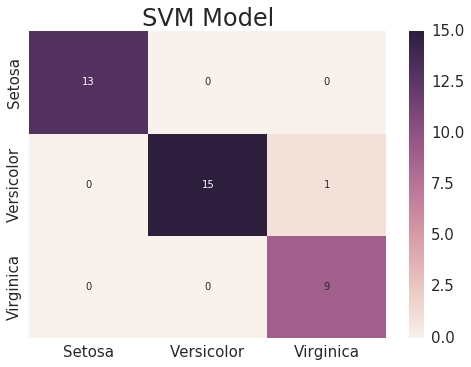

In [6]:
from helper_code import mlplots as mlp

mlp.confusion(l_test, l_pred, ['Setosa', 'Versicolor', 'Virginica'], 3, 'SVM Model')

In [7]:
# First we analyze the PCA compressed data by using SVC.

pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)

# We want to split our data into training and testing

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_reduced, labels, test_size=frac, random_state=0)

# Lets build our model
svc = svm.SVC(kernel='linear', C=1)
svc.fit(d_train, l_train)

# Now grab the predictions
result = svc.predict(d_test)

print("PCA/SVM prediction accuracy = {0:5.1f}%\n".format(100.0 * svc.score(d_test, l_test)))

from sklearn.metrics import classification_report

l_pred = svc.predict(d_test)
print(classification_report(l_test, l_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

PCA/SVM prediction accuracy =  97.4%

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        13
 Versicolor       1.00      0.94      0.97        16
  Virginica       0.90      1.00      0.95         9

avg / total       0.98      0.97      0.97        38



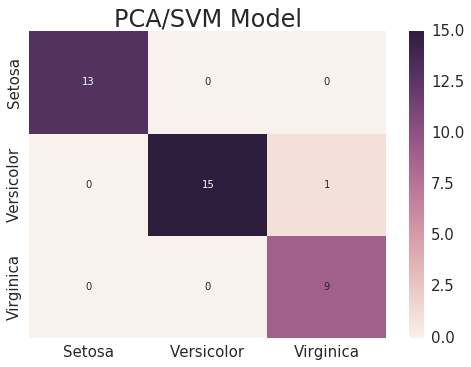

In [8]:
mlp.confusion(l_test, l_pred, ['Setosa', 'Versicolor', 'Virginica'], 3, 'PCA/SVM Model')

-----

As you can see, the PCA transformation cut the data volume in half, and
(at least with the fraction of training data set to 80\%) produced
nearly identical in the SVM classification (note since there is a random
selection of train/test data, your results might be different).

-----

-----

## Student Activity

In the preceding cells, we used PCA to transform the Iris data and
explored the impact of the reduced dimensionality on a simple
classification. Now that you have run this Notebook once, go back and
make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
80%:20% to 75%:25% and to a 50%:50%?
2. Try using the three PCA dimensions for the classification, how do the results change?
3. Try using only the top PCA dimension for the classification, how do the results change?
4. Try using a different dimension reduction technique, such as Random
izedPCA, KernelPCA, or Non-Negative Matrix Factorization.

-----

## Handwritten Digits

Now we switch to a second type of data and explore PCA applied to the
handwritten digit data set. First we will load the data and review some
of the sample. After which, we will apply PCA to see how many features
are required to capture the majority of the variance. We also will look
at the resulting 'images', when reconstructed form a limited set of
components.

-----

Total number of samples = 1797


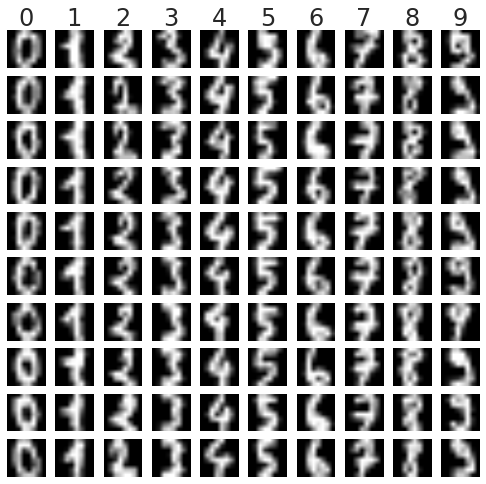

In [9]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

# Compute PCA for these data
pca = PCA(copy=True).fit(x)

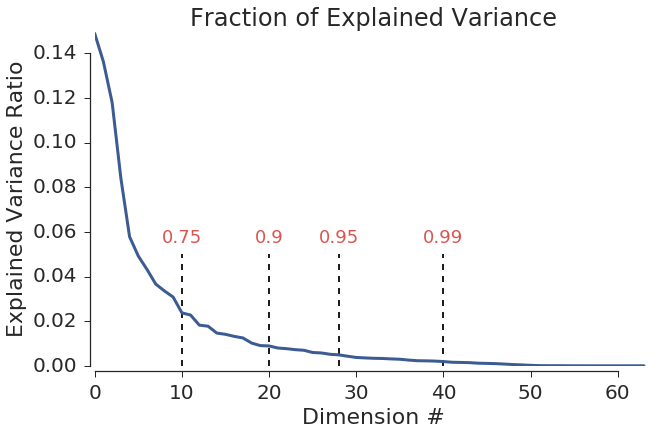

In [10]:
# We compute the cumulaive variance
lmts = [0.75, 0.9, 0.95, 0.99]
vars = np.cumsum(pca.explained_variance_ratio_)
vls = np.array([np.argmax(vars > i) for i in lmts])

#sns.set(style="white")
sns.set(style="ticks", font_scale=2.0)
 
fig, ax = plt.subplots(figsize=(10,6))

# Decorate the plot
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')

ax.set_xlim(0, 64.0)
ax.set_ylim(0, 0.15)

# Draw lines for the cumulative variance
ax.vlines(vls, 0.0, 0.05, linestyles='dashed') #colors=sns.xkcd_rgb)
for xl, txt in zip(vls, lmts):
    ax.text(xl, 0.055, str(txt), fontsize = 18, \
            color=sns.xkcd_rgb["pale red"], \
            horizontalalignment='center')
    
# Now draw the points, with bolder colors.
plt.plot(pca.explained_variance_ratio_, color=sns.xkcd_rgb["denim blue"], linewidth=3)

sns.despine(offset=5, trim=True)

-----

### Classification of image data

Now that these data are loaded, we can apply a GBT  to this problem.
Below we employ the Gradient Boosted Tree model, and show the
classification score, the classification report, and the confusion
matrix.

-----

Total number of PCA Components = 64


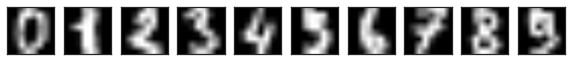

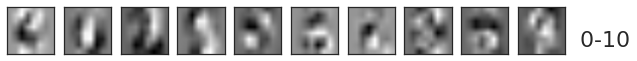

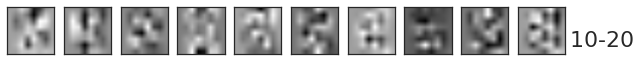

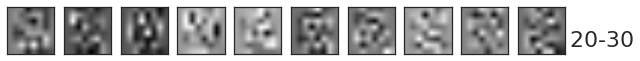

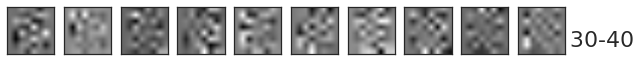

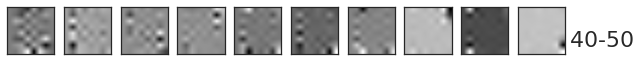

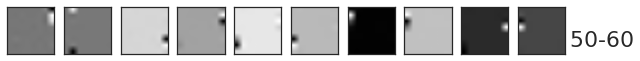

In [11]:
hd.plot_numbers(x[0:10])

pca = PCA()
pca.fit_transform(x)
print('Total number of PCA Components = {0}'.format(pca.n_components_))

for npc in range(0, 60, 10):
    hd.plot_numbers(pca.components_[npc:npc + 10])
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('     {0:6d}-{1:2d}'.format(npc, npc + 10), rotation=0)

-----

### Reconstruction

We can vary the number of components in PCA and see the quality of the reconstructed data.


-----

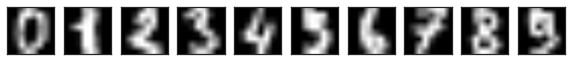

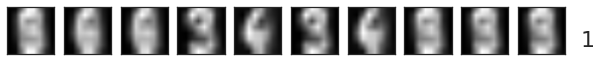

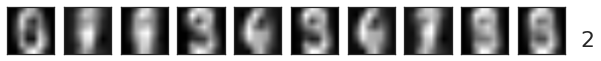

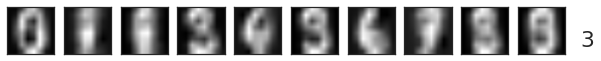

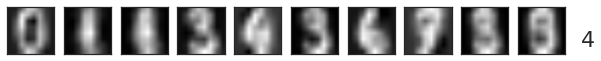

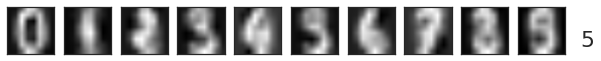

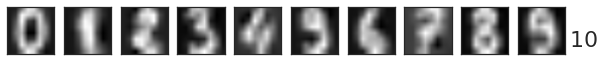

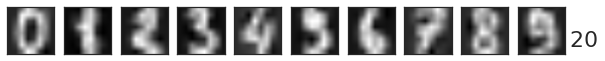

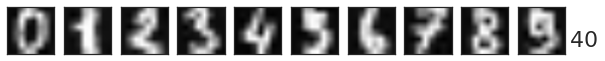

In [12]:
hd.plot_numbers(x[0:10])

ncps = [1, 2, 3, 4, 5, 10, 20, 40]
for npc in ncps:
    pca = PCA(n_components=npc, copy=True)
    tx = pca.fit_transform(x)
    hd.plot_numbers(pca.inverse_transform(tx)[0:10])
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('{0:6d}'.format(npc), rotation=0)


-----

### Covariance Matrix

-----

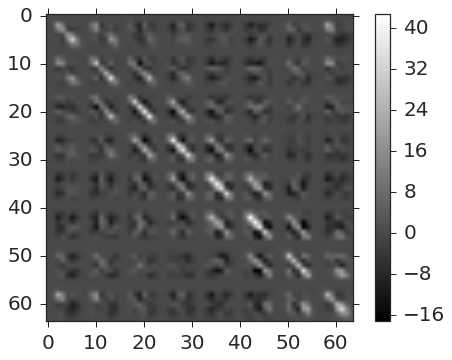

In [13]:
pca = PCA(n_components=npc, copy=True)
pca.fit(x)

plt.imshow(pca.get_covariance())
plt.colorbar()

-----

### Model Evaluation

The GBT model performed in a reasonable manner, but what about on
completely blind data. We can test the model by _making_ new data. Below
we use methods in the helper code to make _fake_ data, in this case
images of **one** and **seven**. We display the _fake_ images, and then
the results of our model classifying these new data.

-----

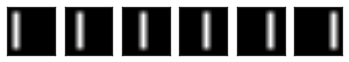

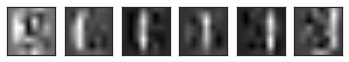

In [14]:
# Test on our sevens

ones = hd.make_ones()

hd.plot_numbers(ones)

# You can change the values to make other numbers.

pca = PCA(n_components=20, copy=True).fit(x)
t_ones = pca.transform(ones)

hd.plot_numbers(pca.inverse_transform(t_ones))

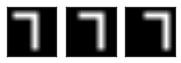

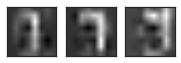

In [15]:
# Test on our sevens

sevens = hd.make_sevens()

hd.plot_numbers(sevens)

# You can change the values to make other numbers.

pca = PCA(n_components=20, copy=True).fit(x)
t_sevens = pca.transform(sevens)

hd.plot_numbers(pca.inverse_transform(t_sevens))

-----
## Technique Comparison

-----

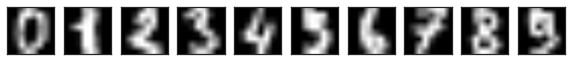

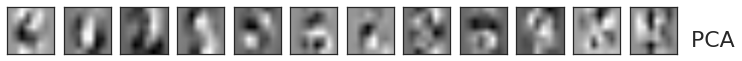

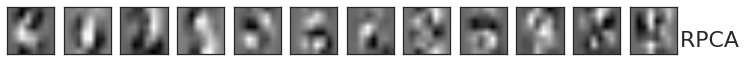

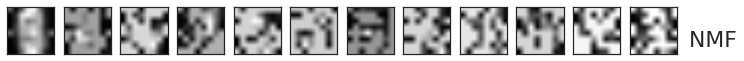

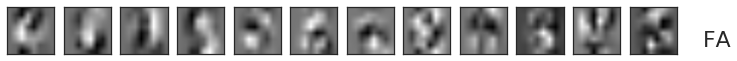

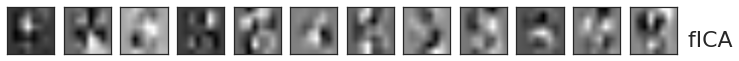

In [16]:
# Principal Component Analysis
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import FastICA


npc = 12
pca = PCA(n_components=npc, copy=True)
rpca = RandomizedPCA(n_components=npc)
nmf = NMF(n_components=npc, init='nndsvda', tol=5e-3)
fa = FactorAnalysis(n_components=npc, max_iter=2)
fica = FastICA(n_components=npc)

hd.plot_numbers(x[:10])

adr = [pca, rpca, nmf, fa, fica]
nam = ['PCA', 'RPCA', 'NMF', 'FA', 'fICA']
for dr, nm in zip(adr, nam):
    tx = dr.fit(x)
    hd.plot_numbers(dr.components_[: npc])
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.set_ylabel('{0:>12s}'.format(nm), rotation=0)

-----

## Student Activity

In the preceding cells, we used a Gradient Boosted Tree model to predict
classifications for the digit data. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the GBT, for example `loss` and
`learning_rate`. Read the code documentation to learn about the default
parameters.
3. Change the metric in the accuracy plot, for example, use `f1_score`.
How did the results change? Trying changing the parameters in the GBT
classifier and seeing how the accuracy is altered.

Finally can you explain (feel free to use the class forums) why the
model performed in the  manner it did for the _fake_ digits? How did
this compare to the RF model?

-----